# DMD on signals with low temporal frequency

In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np

Generate the signal on which DMD will be performed. This signal is the superposition of two sinusoids with different frequencies, plus some noise.

In [2]:
signal_generator = SignalGenerator(t_length=24)
signal_generator.make_signal(which="slow", noise_std=0.1)

Plot the two sinusoids and the signal.

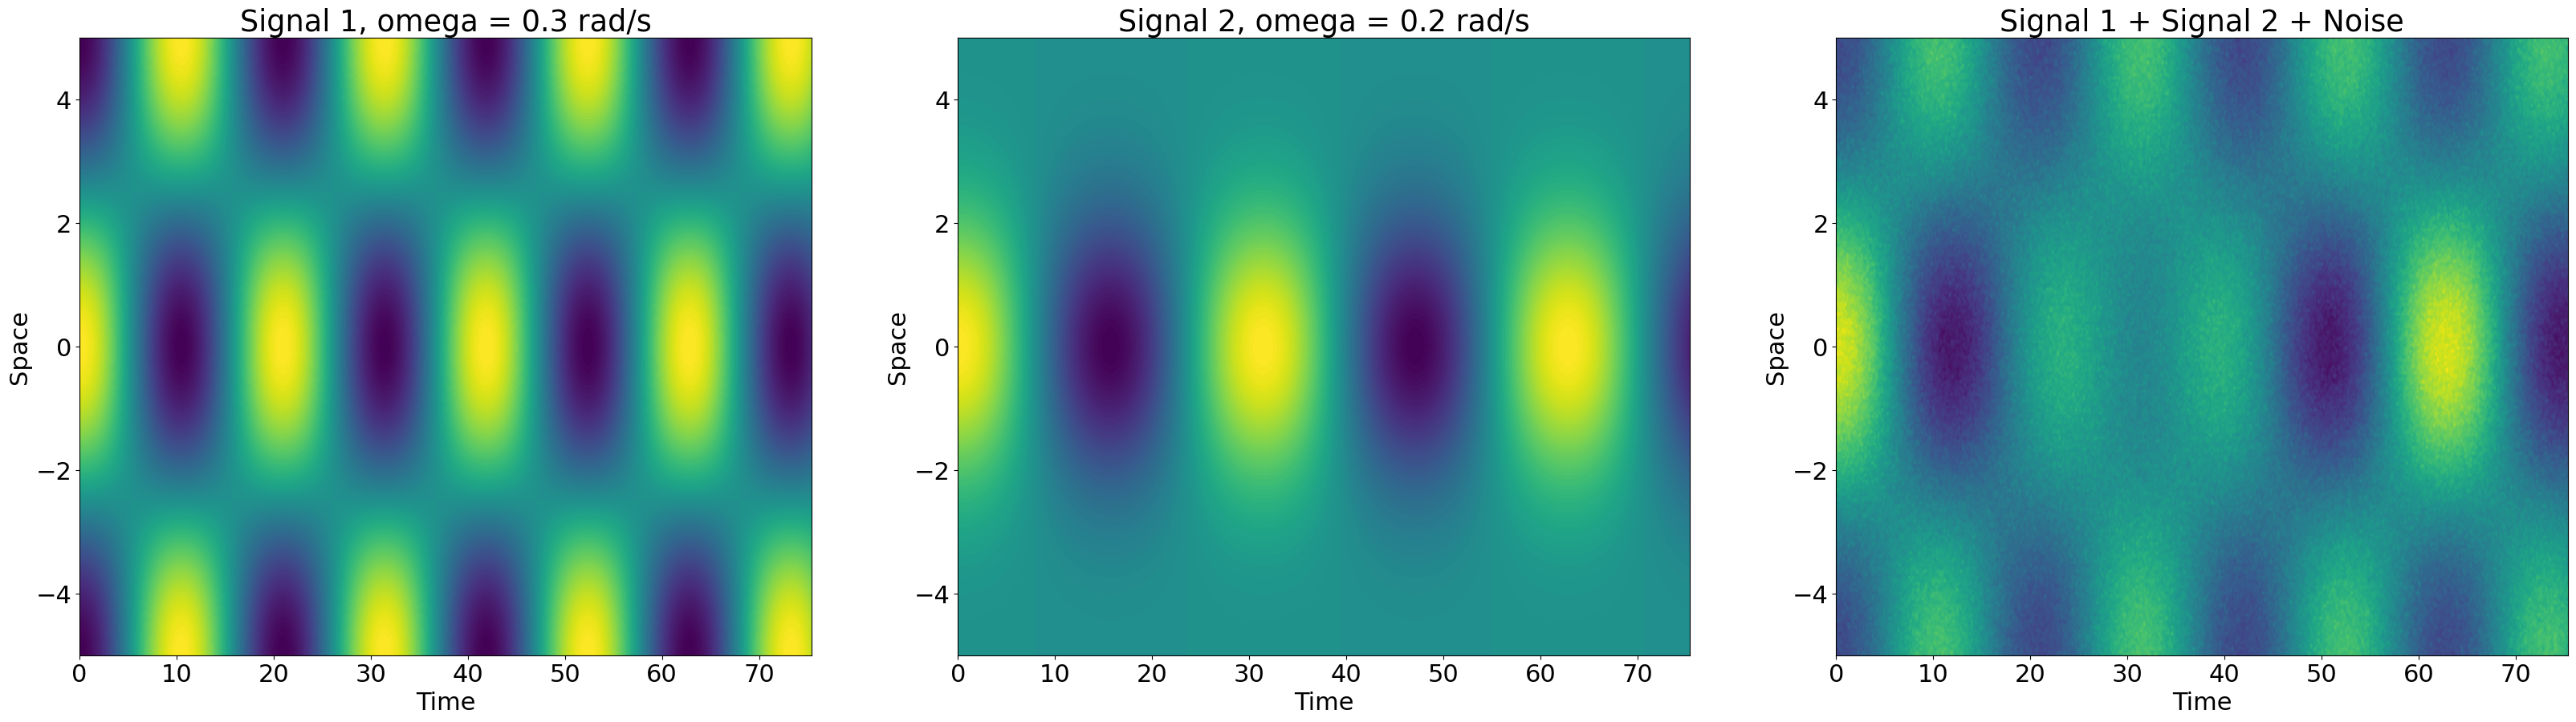

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(1, 3, 1)
ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_slow, 100, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.omega_f1slow} rad/s')

ax = fig.add_subplot(1, 3, 2)
ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_slow, 100, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.omega_f2slow} rad/s')

ax = fig.add_subplot(1, 3, 3)
ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f, 100, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Signal 1 + Signal 2 + Noise')

plt.show()

Perform optimized DMD using the BOPDMD class.

In [4]:
svd_rank = 4  # the signal is composed of two distinct modes, so we need 2 DMD eigenvalues for each oscillation
delay = 2  # need time delay embedding to be able to recover the rank-4 structure
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0)
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

In [5]:
# fit DMD model to 80% of the data
train_frac = 0.8
f_train = signal_generator.f[:int(train_frac * signal_generator.f.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.f.shape[0])]
f_test = signal_generator.f[int(train_frac * signal_generator.f.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.f.shape[0]):]

In [6]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Analyze the results.

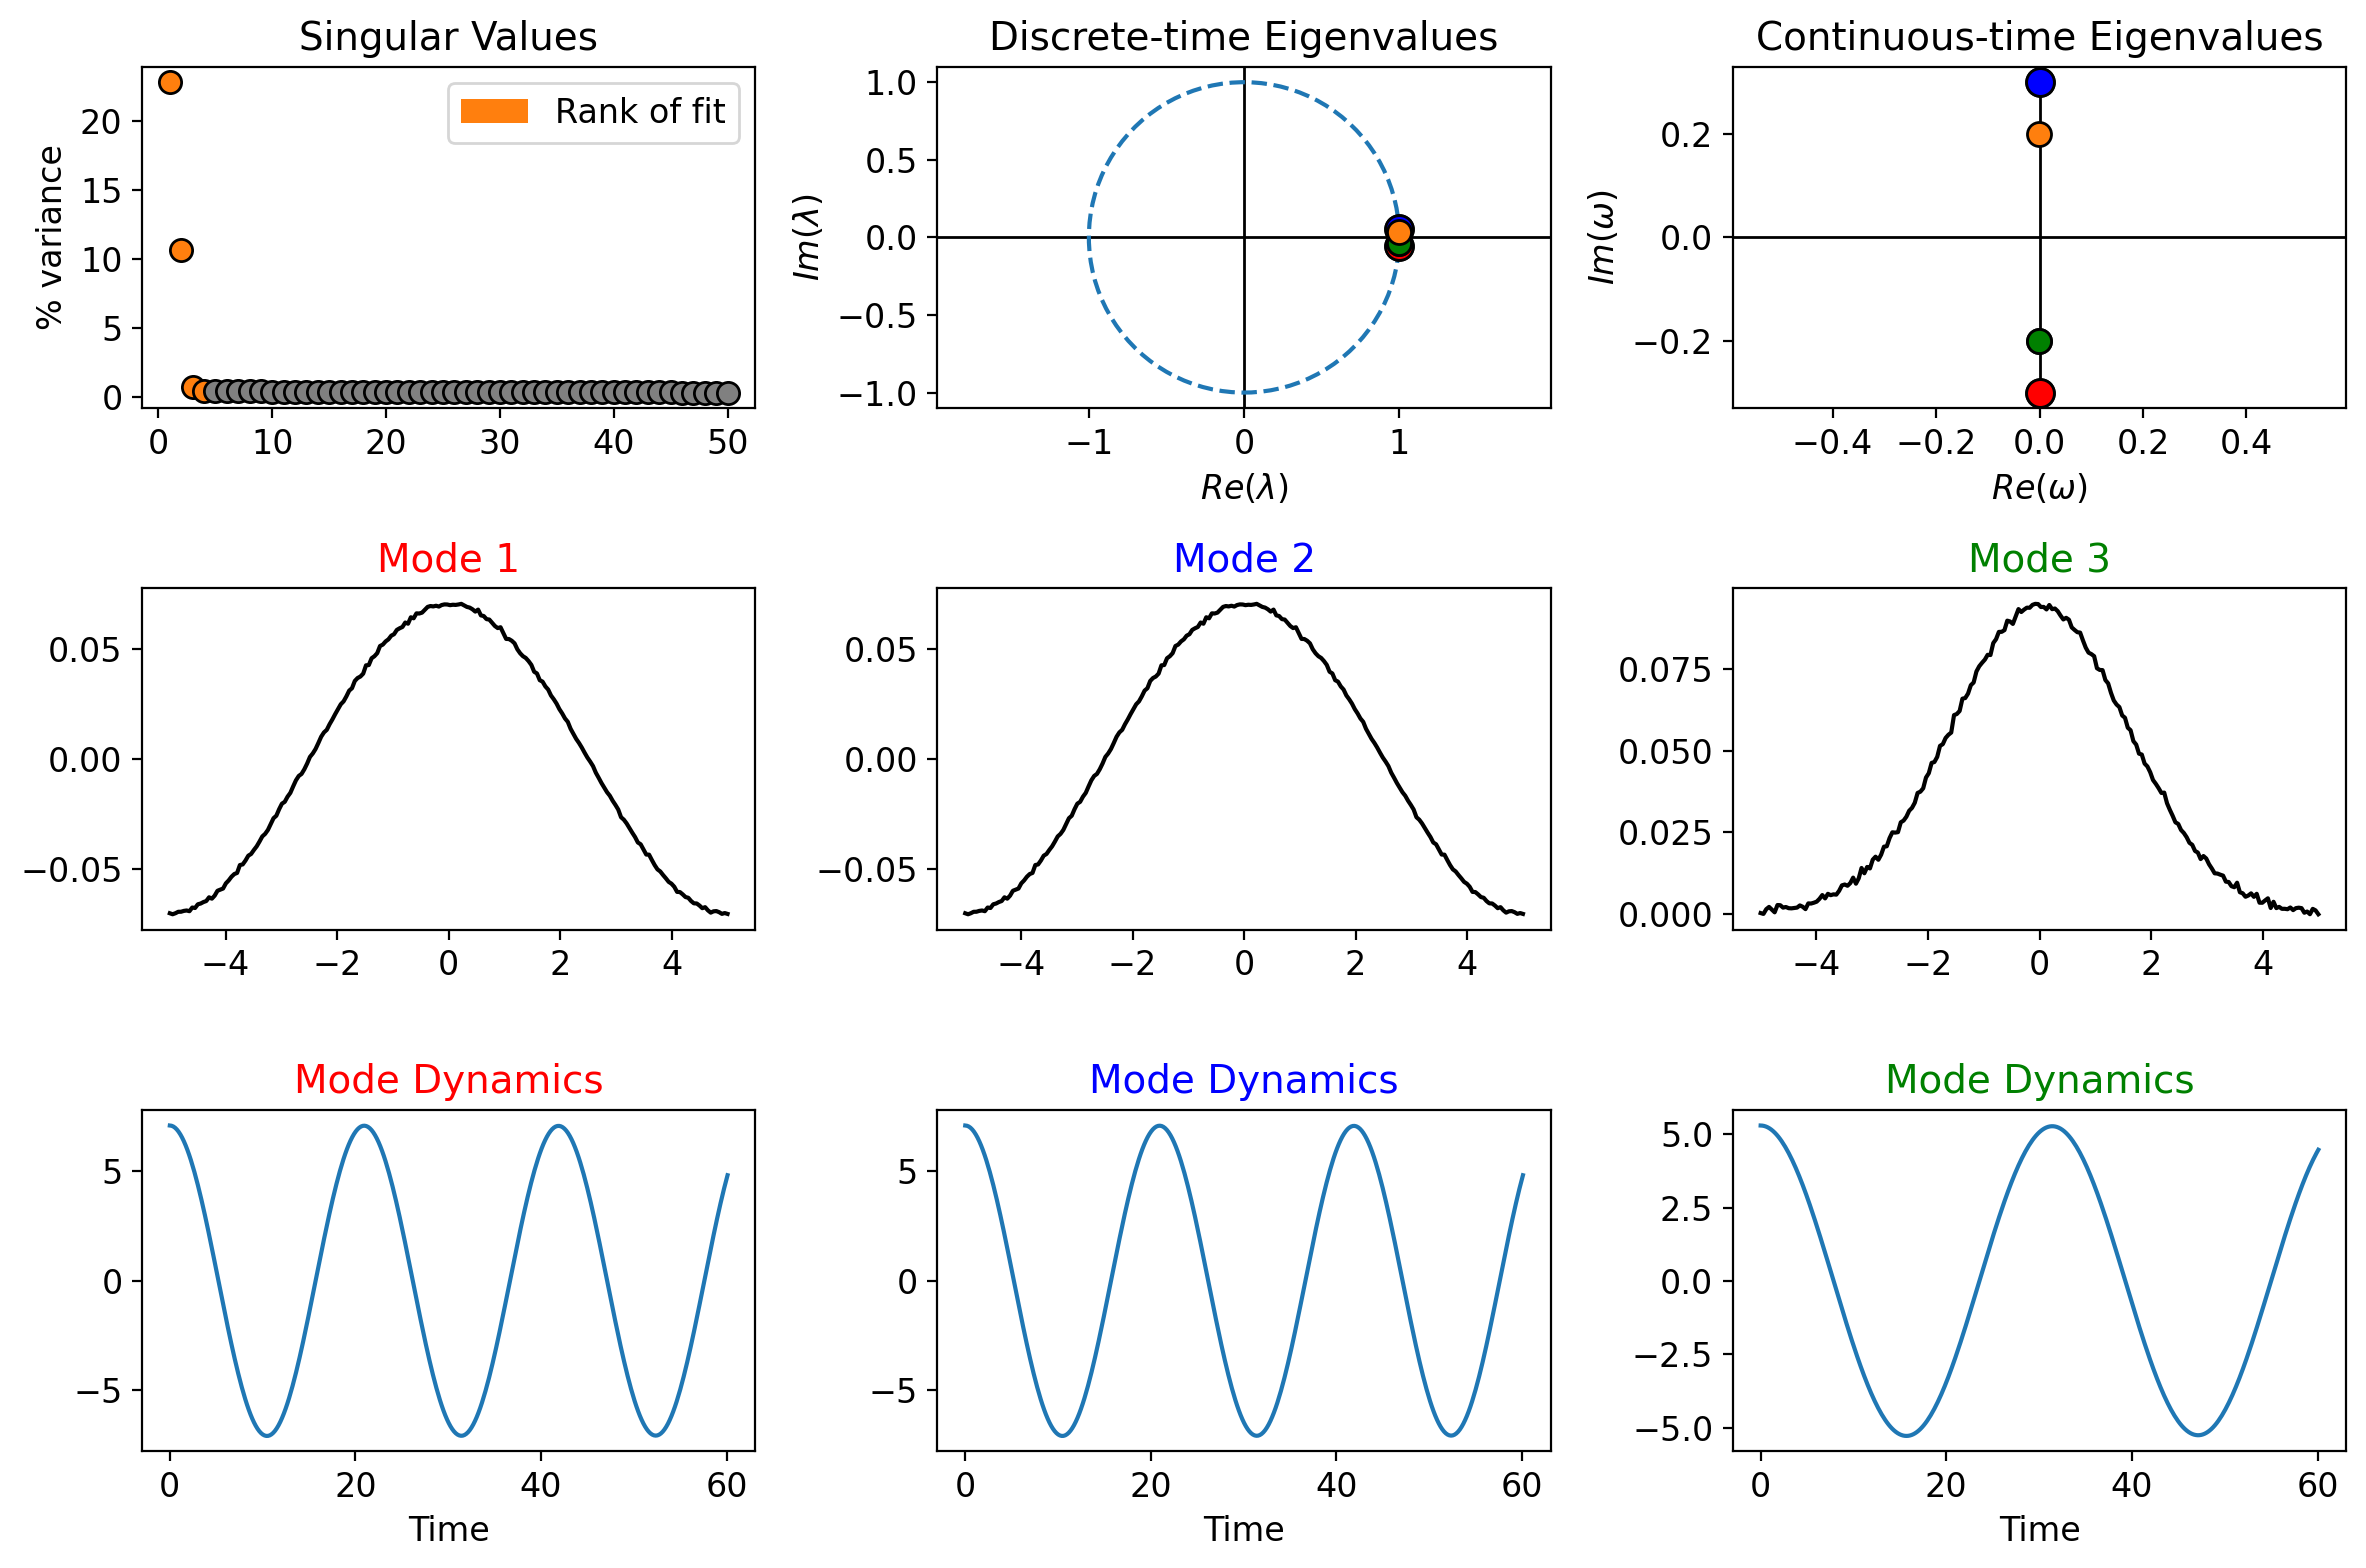

In [7]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay)

The imaginary part of the DMD eigenvalues shows that DMD can accurately extract the two frequencies of the signal.

In [8]:
delay_optdmd.eigs

array([-5.49057340e-05+0.30002958j, -5.49057340e-05-0.30002958j,
       -1.43200755e-04+0.19992636j, -1.43200755e-04-0.19992636j])

Perform a forecast, and compare to the original signal.

In [9]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

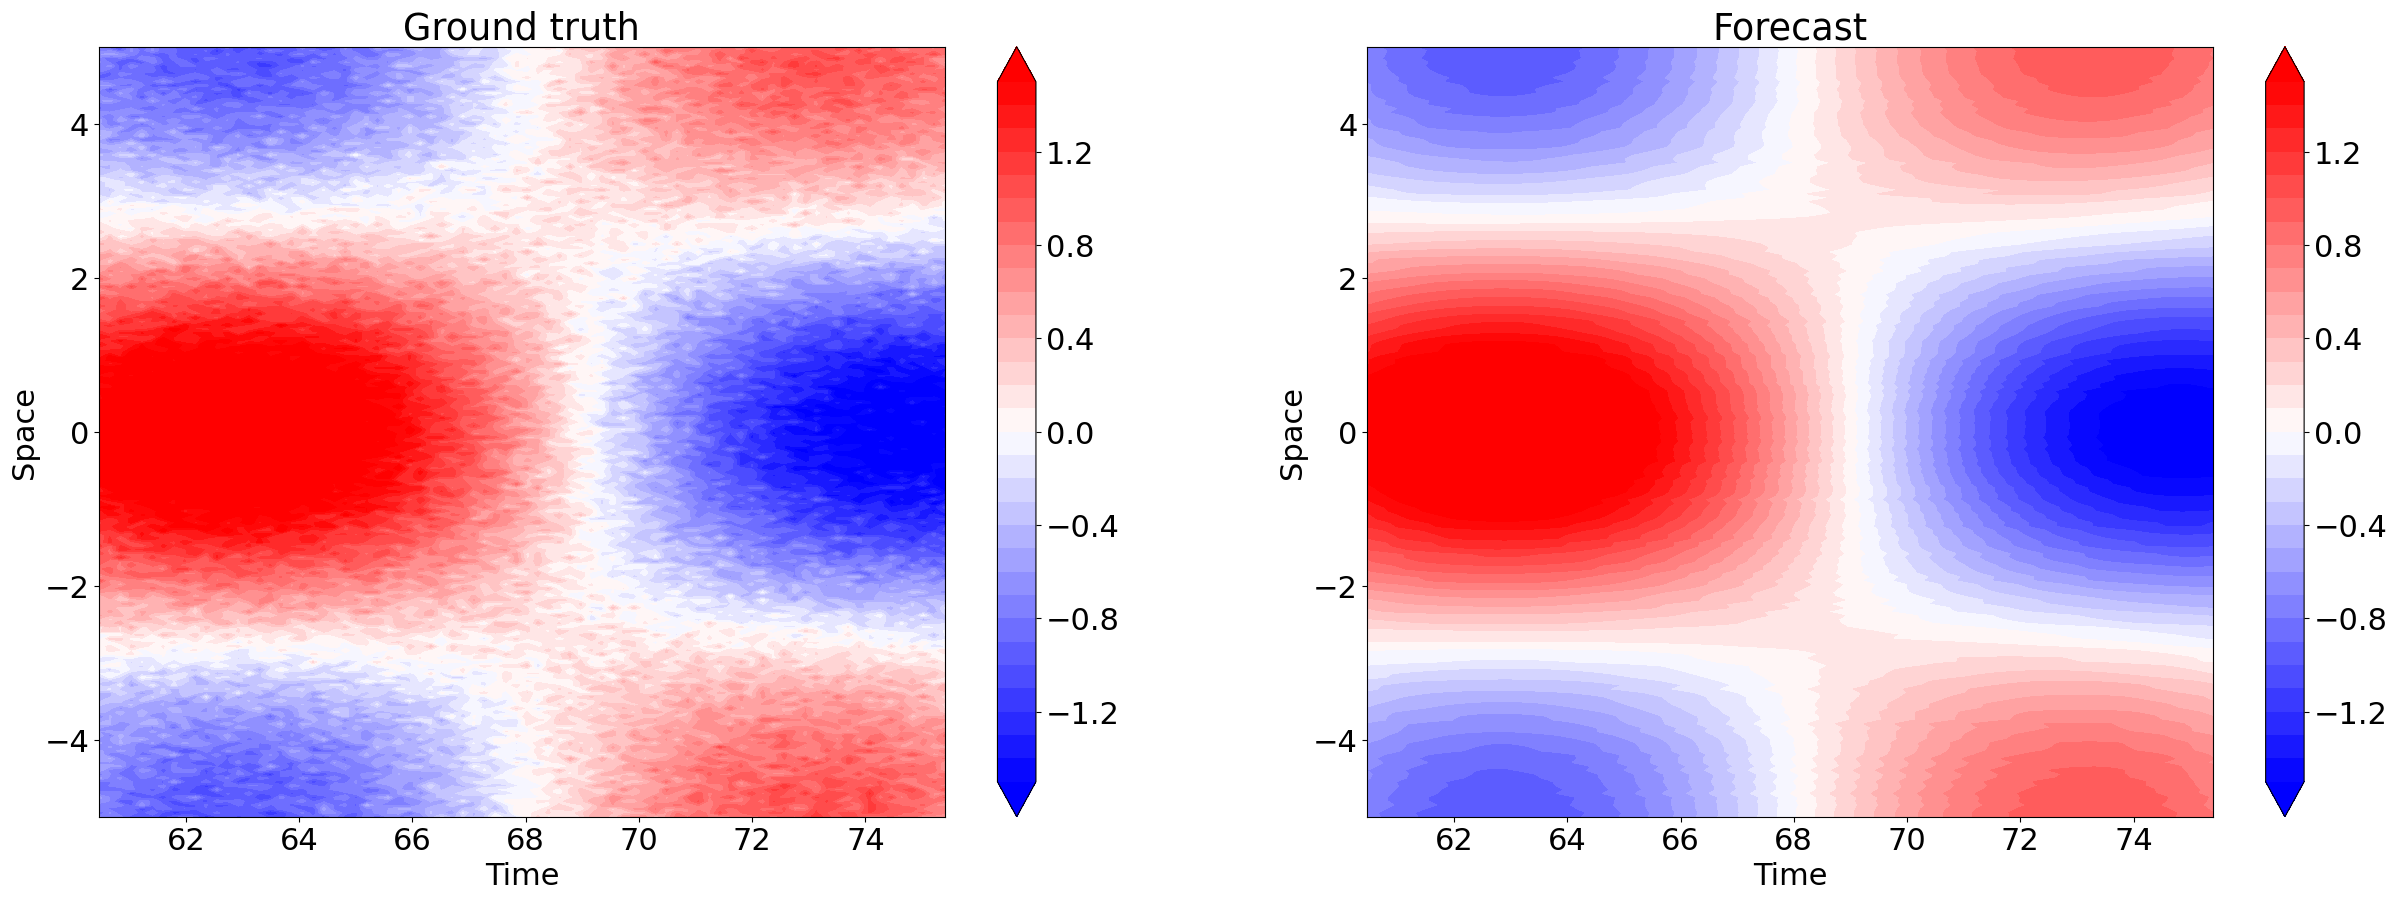

In [10]:
plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(30, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 2, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 2, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()